# Step 1: Isolate cuscuta

- Define a set threshold to remove most of the background
    - This is possible because all the images have roughly the same light conditions
- We already know the linear approximation of the skewers and the location of the tape bands
- With that information, we can divide the original image into 5 overlapping subimages
- Define a custom threshold for each subimage depending on the remaining skewer pixels
- Extract cuscuta as the largest connected components that are close to the skewer and that are not too oblong

In [1]:
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage import morphology

import os
import pandas as pd

In [2]:
buffx = 0
buffX = 1475
buffy = 200
nsamples = 5

src = '../raw/'
dst = '../proc/skel/'

In [3]:
time = '4pm'
rep = 7

dst = dst + '{}_rep{}/'.format(time,rep)
if not os.path.isdir(dst):
    os.mkdir(dst)
    for i in range(nsamples):
        os.mkdir(dst + 'plant_{:02d}'.format(i))

meta = pd.read_csv('../reference/reference_positions_{}_rep{}.csv'.format(time, rep))
meta = meta.set_index('numidx')
meta.head()

,peaks_0,peaks_1,peaks_2,peaks_3,peaks_4,tapes_0,tapes_1,tapes_2,tapes_3,tapes_4,coef0_0,coef0_1,coef0_2,coef0_3,coef0_4,coef1_0,coef1_1,coef1_2,coef1_3,coef1_4
numidx,,,,,,,,,,,,,,,,,,,,
1,617,1307,2081,2945,3787,903,992,995,1194,1395,224.909,228.658,190.235,183.072,189.759,-0.017661,-0.021867,0.001748,0.014864,0.009036
2,597,1291,2069,2931,3769,893,980,983,1181,1412,227.745,200.906,186.711,181.974,192.363,-0.017171,0.005466,0.004167,0.015038,0.008791
3,573,1296,2061,2927,3762,903,991,993,1221,1447,236.140,188.049,187.639,183.790,190.927,-0.007194,0.008313,0.003852,0.011888,0.011083
4,583,1296,2064,2930,3766,890,978,979,1174,1402,232.565,181.112,185.558,180.871,187.369,-0.011769,0.015637,0.003632,0.012464,0.010194
5,604,1297,2065,2925,3761,891,976,979,1176,1428,218.414,201.373,184.803,182.785,189.889,-0.017212,-0.003465,0.003809,0.014073,0.009635


In [4]:
idx = 1
foldername = time + ' Inc Rep ' + str(rep)
filename = glob(src + foldername + '/*({})*.JPG'.format(idx))[0]
print(filename)

raw = cv2.imread(filename)
rawstd = np.var(raw, axis=2, ddof=1)
rawmean = np.mean(raw, axis = 2)

graw = raw[:,:,1]
hsv = cv2.cvtColor(raw, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

../raw/4pm Inc Rep 7/4pm Inc Rep 7 (1).JPG


# Remove most of the background and foreground

In [5]:
stdmask = (rawstd > 60) | (rawmean > 210)

hmask = ((h < 40) & (h > 0)) & (v > 60) & stdmask

img = raw.copy()
for i in range(3):
    img[:,:,i] *= hmask

# Find the y-coord for the sticks

In [6]:
tapes = meta.loc[idx, ['tapes_{}'.format(i) for i in range(nsamples)]].values.astype(int)
peaks = meta.loc[idx, ['peaks_{}'.format(i) for i in range(nsamples)]].values.astype(int)
peaks = np.hstack((peaks, min([ raw.shape[1], peaks[-1] + np.max(np.ediff1d(peaks)) ])))

coefs = meta.loc[idx, ['coef0_{}'.format(i) for i in range(nsamples)] + ['coef1_{}'.format(i) for i in range(nsamples)] ].values
coefs = np.reshape(coefs, (nsamples, 2), order='F')

In [7]:
xvals = np.arange(len(raw))
lines = np.zeros((nsamples, len(raw)))
for i in range(len(lines)):
    b0 = peaks[i] + coefs[i,0] - buffy
    lines[i] = b0 + coefs[i,1]*(xvals - buffx)

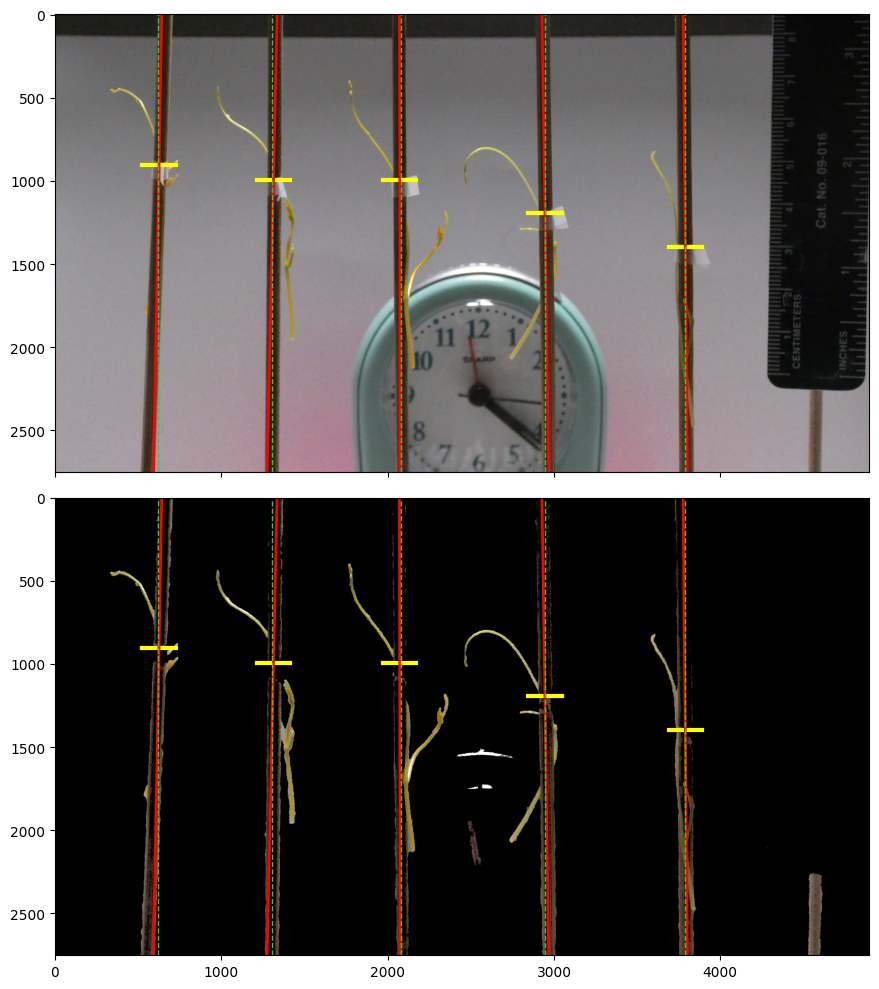

In [8]:
fig, ax = plt.subplots(2,1,figsize=(12,10), sharex=True, sharey=True)
ax[0].imshow(raw[:, :, ::-1])
ax[1].imshow(img[:, :, ::-1])
for i in range(len(ax)):
    for j in range(len(lines)):
        ax[i].plot([lines[j,tapes[j]]-100, lines[j,tapes[j]]+100], [buffx+tapes[j], buffx+tapes[j]], c='yellow', lw=3)
        ax[i].plot(lines[j], xvals, c='red', lw=2)
        ax[i].axvline(peaks[j], c='limegreen', ls='--', lw=1)
fig.tight_layout()

# Separate the sticks and cuscuta

In [9]:
buffz = 50
plants = [ np.s_[buffx:tapes[0]+buffx, 0:peaks[1]-buffz] ]

for i in range(1,len(tapes)):
    plants.append(np.s_[buffx:tapes[i]+buffx, peaks[i-1]+buffz:peaks[i+1]-buffz])
plants

[(slice(0, 903, None), slice(0, 1257, None)),
 (slice(0, 992, None), slice(667, 2031, None)),
 (slice(0, 995, None), slice(1357, 2895, None)),
 (slice(0, 1194, None), slice(2131, 3737, None)),
 (slice(0, 1395, None), slice(2995, 4601, None))]

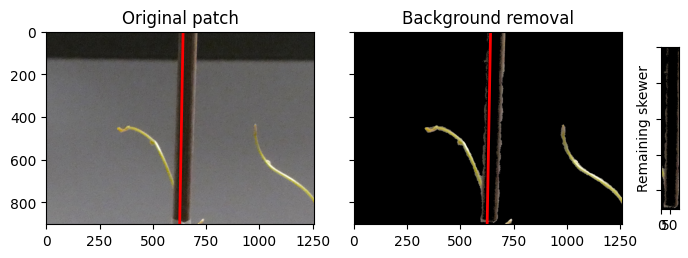

In [17]:
pidx = 0
xlen = xvals[ plants[pidx][0] ] - plants[pidx][0].start
line = lines[ pidx, plants[pidx][0] ] - plants[pidx][1].start
patch = img[plants[pidx]][:,:,::-1]

skewers = np.zeros((len(line), 2*buffz, 3), dtype=np.uint8)
for i in range(len(skewers)):
    foo = int(line[i])
    skewers[i] = patch[i, foo-buffz:foo+buffz, :]

fig, ax = plt.subplots(1,3,figsize=(7,4), sharex=False, sharey=True, width_ratios=[15,15,1])
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(raw[plants[pidx]][:,:,::-1]);
ax[1].imshow(patch);
ax[2].imshow(skewers)

ax[0].set_title('Original patch')
ax[1].set_title('Background removal')
ax[2].set_ylabel('Remaining skewer')

for i in range(2):
    ax[i].plot(line, xlen, color='red', lw=2);

fig.tight_layout()

# Try to remove remaining bits of skewer

- We are going to work only with the green channel
- There might be still bits of skewer left
- We are going to get a sense of what's the 80th quantile value of all the remaining non-zero skewer pixels in the red channel
- Then threshold the hold patch
- It is important to take into account how much of skewer is there to remove in the first place
- Define minimum and maximum thresholding values

In [18]:
median = ndimage.median_filter(patch[:,:,1], size=9)
skewer = skewers[:,:,1].copy()
#skewer[:, 15:-15] = 0
    
nonzeroratio = np.sum(skewer > 0)/skewer.size
print('Ratio of non-zero pixels in the skewer:\t{:.2f}%'.format(nonzeroratio*100))

if len(skewer[skewer > 0]) < 10:
    threshold = mind
else:
    q = np.max([0.25, (1 - nonzeroratio)*0.5])
    #q = 1 - nonzeroratio
    threshold = np.quantile(skewer[skewer > 0], q)
    print('Quantile {:.2f} of nonzero skewer:\t'.format(q), threshold)
    threshold = np.min([115, threshold])
    threshold = np.max([50, threshold])
    #bar = np.floor(50 + bar*(foo - 50))

print('Thresholding by:\t',threshold)
median[median < threshold] = 0
median[median > 0] = 1
#median = ndimage.binary_dilation(median, iterations=5)

labels,num = ndimage.label(median, structure=ndimage.generate_binary_structure(2,1))

Ratio of non-zero pixels in the skewer:	21.20%
Quantile 0.39 of nonzero skewer:	 60.0
Thresholding by:	 60.0


# Only keep the large chunks that are close to the central axis

- Get all the connected components of the thresholded patch
- Compute geometrical shape descriptors for each connected component
- We will later drop those that are either:
    - Too oblong
    - Far away from the central axis
    - Too small (in both absolute and relative terms)
    - Too narrow


In [19]:
minsize = 100
comp_size = np.zeros(num, dtype=int)
feret = np.zeros((num,2))
touch = np.zeros((num,4))
dtouch = np.zeros(num, dtype=int)

for i in range(num):
    box = median.copy()
    box[labels != i+1] = 0

    coords = np.asarray(np.nonzero(box))
    feret[i] = np.max(coords, axis=1) - np.min(coords, axis=1) + np.array([1,1])
    comp_size[i] = len(coords[1])
    
    foo = np.abs(line[coords[0]] - coords[1])
    
    bar = np.argmin(foo)
    dtouch[i] = foo[bar]
    touch[i,:2] = coords[:,bar]
    
f_ratio = np.divide(*np.sort(feret, axis=1).T) 

In [20]:
comp_mask = ( (feret[:,1] > 30) | (f_ratio > 0.35) | (dtouch < 5) ) & (comp_size > 100) & (dtouch < 75) & (f_ratio > 0.075)

size_mask = comp_size/np.sum(comp_size[comp_mask]) > 0.04

mask = comp_mask & size_mask

box = np.zeros_like(labels).astype(bool)
comp_labels = np.nonzero(mask)[0]

for i in comp_labels:
    box[labels == i+1] = True

print(comp_size[comp_mask])
print(comp_size[comp_mask]/np.sum(comp_size[comp_mask]))

[10914   515]
[0.95493919 0.04506081]


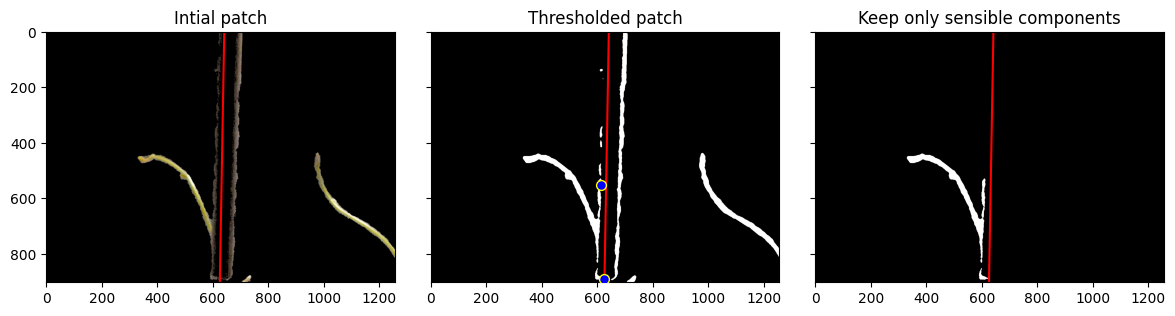

In [21]:
fig, ax = plt.subplots(1,3,figsize=(12,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(patch, origin='lower', cmap='Greys_r', vmax=1);

ax[1].imshow(median, cmap='Greys_r', vmax=1)
ax[1].scatter(touch[mask, 1], touch[mask, 0], c='blue', zorder=3, s=50, edgecolor='yellow')
ax[2].imshow(box, cmap='Greys_r', vmin=0, vmax=1)

ax[0].set_title('Intial patch')
ax[1].set_title('Thresholded patch')
ax[2].set_title('Keep only sensible components')

for i in range(len(ax)):
    ax[i].plot(line, xlen, c='red')

fig.tight_layout();

# Skeletonize and save

- The rest of downstream analysis will use only information related to the skeleton and the skewer-line-approximation.
- Thus we just need to save the skeleton
- The rest of information is already in the `meta` file from the previous notebook or it can be recomputed easily.

In [22]:
skel = morphology.thin(box)
coords = np.asarray(np.nonzero(skel))

In [23]:
filename = dst + 'plant_{:02d}/{}_rep{}_p{:02d}_{:04d}.csv'.format(pidx, time, rep, pidx, idx)
np.savetxt(filename, coords, fmt='%d', delimiter=',')

# Scratch 

In [ ]:
anchory = peaks[pidx]-plants[pidx][1].start
skel = morphology.thin(box)
ceros = np.zeros(4, dtype=int)
cero = np.nonzero(np.any(box, axis = 1))[0][np.asarray([0,-1])]
ceros[:2] = cero
print(ceros)
print(box.shape, skel.shape, erode[pidx].shape, peaks[pidx], anchory, buffy)
print(anchory-buffy, anchory+buffy)

comb = box[ceros[0]:ceros[1], : ].copy().astype(np.uint8)
comb[:, anchory-buffy:anchory+buffy] += 2*(erode[pidx][ceros[0]:ceros[1], :]).astype(np.uint8)

cero = np.nonzero(np.any(comb != 0, axis = 0))[0][np.asarray([0,-1])]
ceros[2:] = cero
ss = np.s_[ceros[0]:ceros[1], ceros[2]:ceros[3]]
print(ss)

comb = comb[:, ceros[2]:ceros[3]]*2
comb[comb == 4] = 1
comb[comb == 2] = 3
comb[comb == 6] = 4
#comb[comb == 1] = 2 

comb[ skel[ss] ] += 2

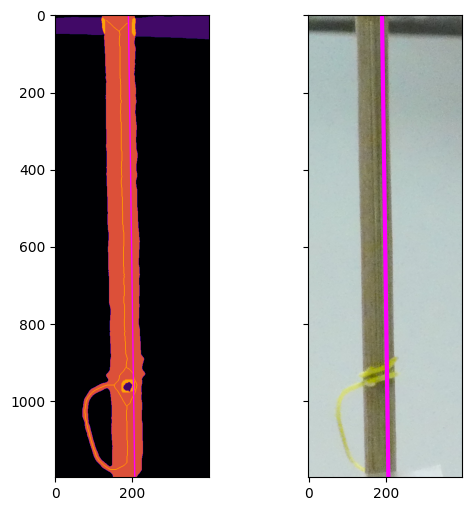

In [81]:
fig, ax = plt.subplots(1,2,figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(comb, cmap='inferno', vmin=0, zorder = 2);
#ax[0].axvline(anchory-ceros[2], color='lime', lw=1, ls='--');
ax[0].plot(line[np.arange(ceros[0],ceros[1])] - ceros[2], range(ceros[1]-ceros[0]), color='magenta', lw=1);

ax[1].imshow(raw[plants[pidx]][ss][:,:,::-1], cmap='inferno', vmin=0, zorder = 2);
#ax[1].axvline(anchory-ceros[2], color='lime', lw=3, ls='--');
ax[1].plot(line[np.arange(ceros[0],ceros[1])] - ceros[2], range(ceros[1]-ceros[0]) , color='magenta', lw=3);

In [18]:
filename = pdst + 'plant_{:02d}/{}_rep{:02d}_{:04d}'.format(pidx, time, rep, numidx)
print(filename)

tf.imwrite(filename + '.tif', comb*40, photometric='minisblack')

../proc/prelim/9am_rep3/plant_04/9am_rep03_0772
